# Workshop #5. Basics of `scanpy`

# Hometask

## Task 1

Number of UMIs per cell in the dataset is distributed (approximately) bimodally. What is the reason for that? Please provide some papers and/or resourses when this phenomenon is described.

Потому что есть относительно большая фракция "пустых капель" (empty drops / background / ambient RNA), кол-во UMI в которых значительно меньше, чем в "каплях"/баркодах с одной нормальной клетокой [1,4].

В то же время, насколько я понимаю, кол-во дублетов (а также триплетов и тд) не столь велико, к тому же кол-во UMI в них будет больше в разы, а не на порядки, как с "пустыми каплями", поэтому третьего пика мы не наблюдаем.

Конечно, еще дополнительные пики могут объясняться не техническим шумом, а биологической разницей в типах анализируемых клеток [2].

Ресурсы:
1. https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-02978-x
2. https://hbctraining.github.io/scRNA-seq_online/lessons/04_SC_quality_control.html
3. https://isoseq.how/umi/cell-calling.html – изображение
4. https://www.youtube.com/watch?v=7B9N0rdjBTo – прексрасная лекция


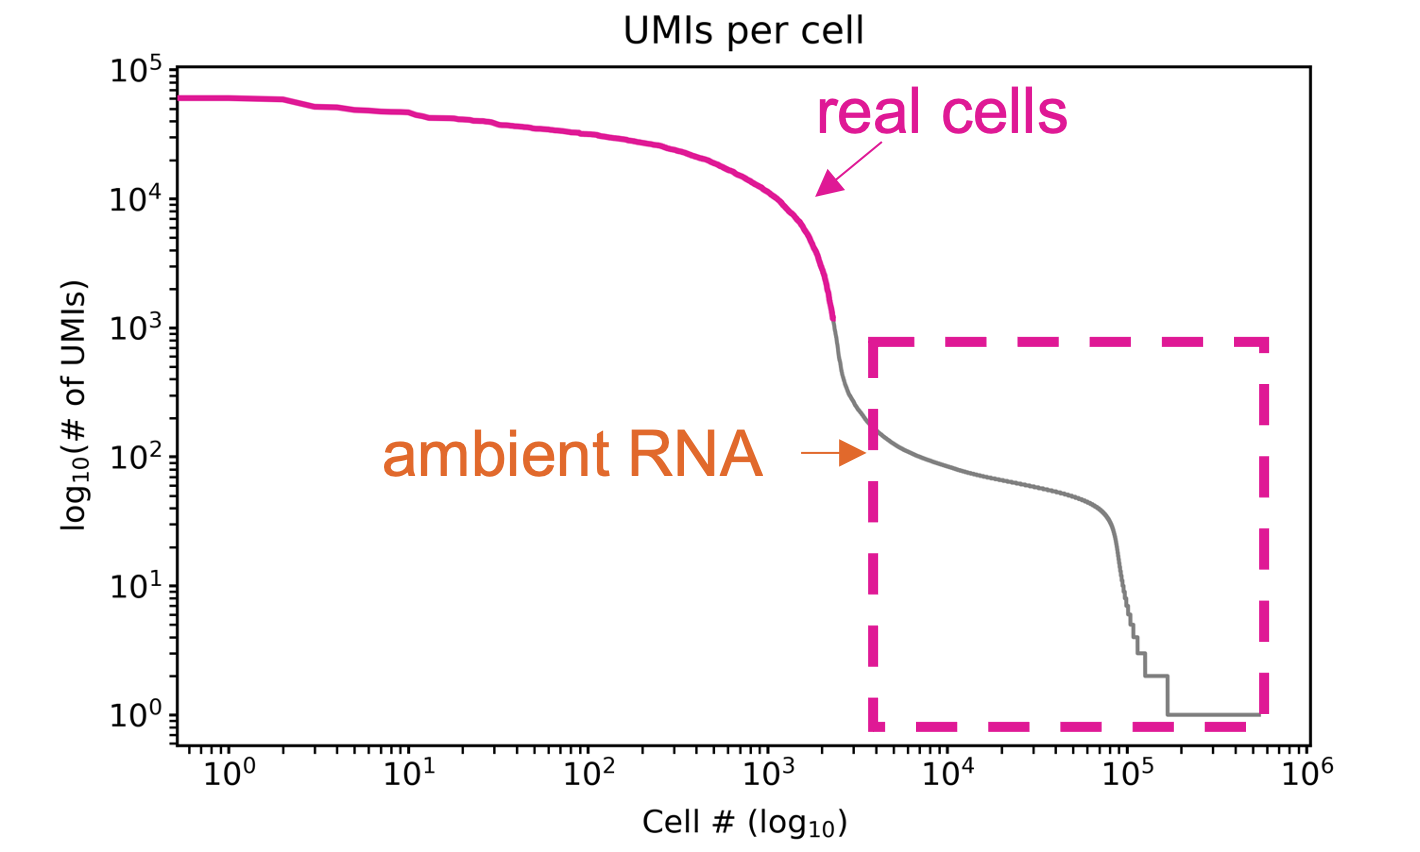

## Task 2

Using [Cellxgene Portal](https://cellxgene.cziscience.com/) please select the dataset of your scientific interest and perform QC. Are you happy with it? Please save files in `loom` format and describe the features of such a format.

In [ ]:
! pip install scanpy[leiden] loompy
# Взял небольшой датасет по крови – Tabula Sapiens - Blood
! wget -O data.h5ad https://datasets.cellxgene.cziscience.com/c18b60ea-7dbc-4705-a3dc-e29da4e43c68.h5ad

In [1]:
import scanpy as sc
import seaborn as sns
import numpy as np

sc.settings.verbosity = 3

In [2]:
adata = sc.read_h5ad("data.h5ad")

In [3]:
adata.var_names_make_unique()

In [8]:
# Супер, митохондриальных генов ровно 37 в аннотации, это радует!
np.unique(adata.var.feature_name.str.startswith("MT-"),
                              return_counts = True)

(array([False,  True]), array([58445,    37]))

In [4]:
adata.var["mt"] = adata.var.feature_name.str.startswith("MT-")

#### Решил пройтись части QC [туториала scanpy](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

In [49]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

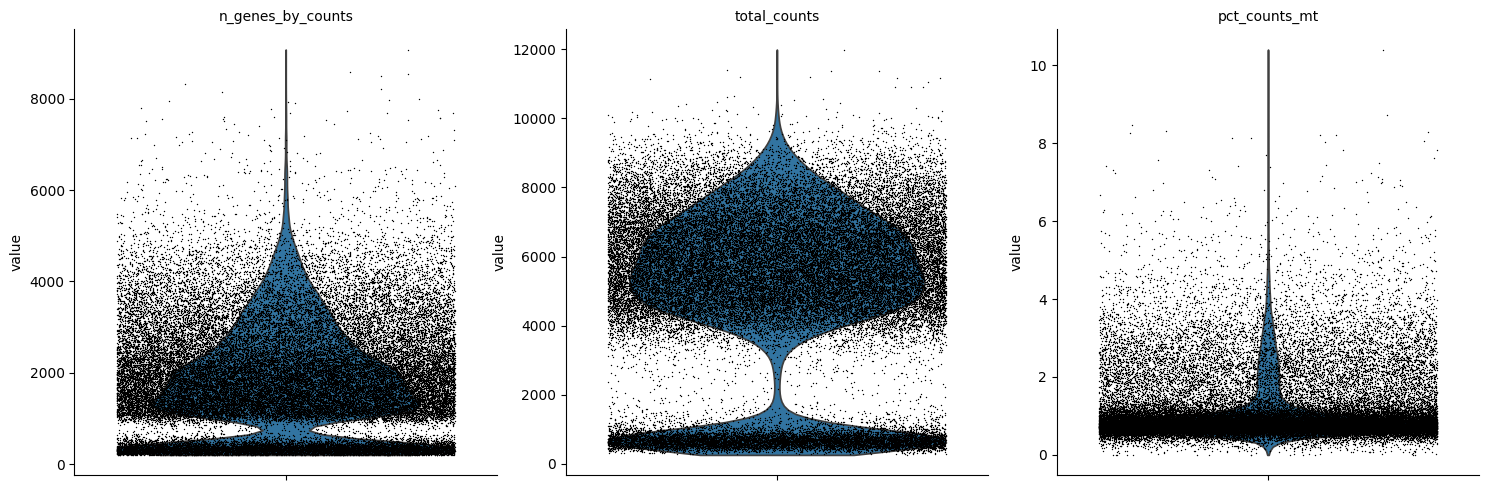

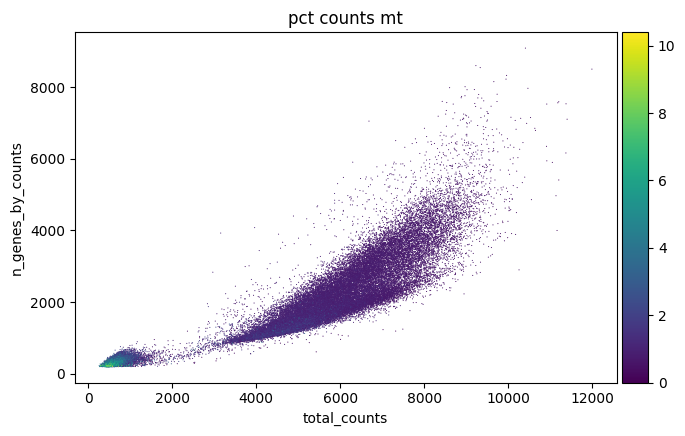

In [52]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

1. Видно, что распределение "total_counts" и "n_genes_by_counts" бимодально – надо фильтровать фракцию пустых клеток
2. Видно фракцию клеток с завышенным процентом митохондриальных каунтов – тоже надо фильтровать

#### QC по туториалу из лекции

<Axes: ylabel='Count'>

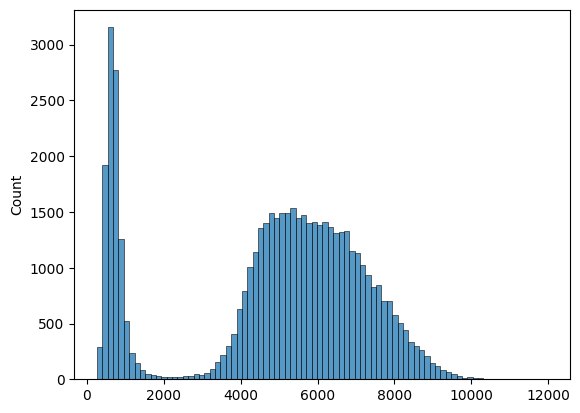

In [53]:
# Распределение UMI на клетку бимодально (см. задание №1 – надо отсекать левый пик)

counts_per_cell = adata.X.sum(axis=1).A.T[0]
sns.histplot(counts_per_cell)

<Axes: ylabel='Count'>

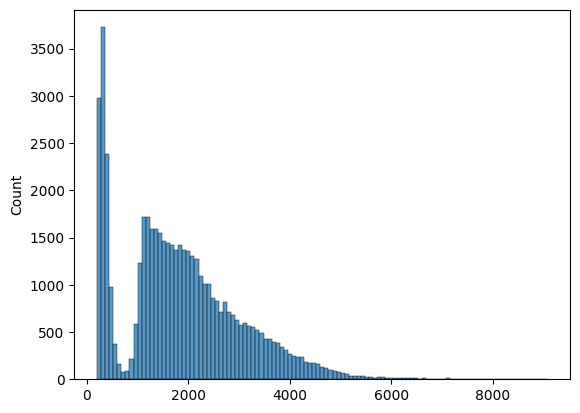

In [54]:
# Распределение кол-ва генов на клетку

genes_per_cell = (adata.X > 0).sum(axis=1).T.A[0]
sns.histplot(genes_per_cell)

<Axes: ylabel='Count'>

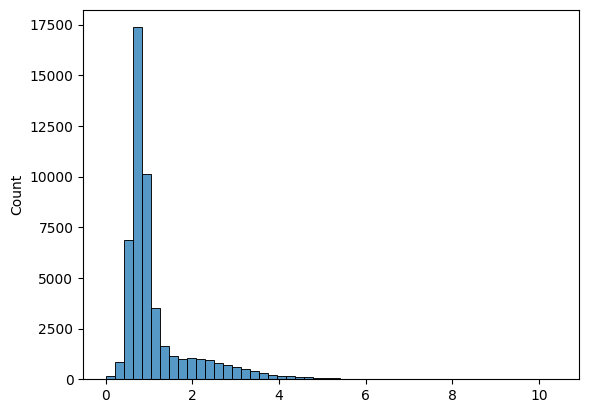

In [55]:
# % of mitochondrial expression per each cell distribution – на этой гистограмме как будто не так хорошо видно ту фракцию, в которой % mt > 6 (на предыдущем они заметнее)

mito_counts = adata[:, adata.var["mt"]].X.sum(axis=1).T.A[0]
mito_pct = mito_counts / counts_per_cell * 100
sns.histplot(mito_pct, bins=50)

In [2]:
! ls -lah

total 1.4G
drwxr-xr-x 1 root root 4.0K Jul 14 12:22 .
drwxr-xr-x 1 root root 4.0K Jul 14 10:04 ..
drwxr-xr-x 4 root root 4.0K Jul 11 13:21 .config
-rw-r--r-- 1 root root 756M Jun  9 05:17 data.h5ad
-rw-r--r-- 1 root root  12K Jul 14 12:22 data.loom
-rw-r--r-- 1 root root  38M Sep  5  2022 filtered_feature_bc_matrix.h5
-rw-r--r-- 1 root root 100M Sep  5  2022 filtered_feature_bc_matrix.tar.gz
drwxr-xr-x 2 root root 4.0K Jul 14 11:43 .ipynb_checkpoints
-rw-r--r-- 1 root root  652 Sep  5  2022 metrics_summary.csv
-rw-r--r-- 1 root root 330M Jul 14 10:05 PBMC_10k.zip
-rw-r--r-- 1 root root  60M Sep  5  2022 raw_feature_bc_matrix.h5
-rw-r--r-- 1 root root 134M Sep  5  2022 raw_feature_bc_matrix.tar.gz
drwxr-xr-x 1 root root 4.0K Jul 11 13:22 sample_data
-rw-r--r-- 1 root root 4.5M Sep  5  2022 web_summary.html


View of AnnData object with n_obs × n_vars = 50115 × 10
    obs: 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_version', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'mt'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'citation', 'dendrogram_cell_type_tissue', 'dendrogram_computational_c

In [10]:
# adata.write_loom("data.loom",  write_obsm_varm=False)
# У меня не получилось сохранить, так как сессия всегда падает по памяти

# adata.X = adata.X.A
# Перевести X в dense из sparse тоже, так как сессия также падает по памяти

# * ненавижу сolab, ненавижу сolab, ненавижу сolab *

# Поэтому я сохранил маааааааленькую adata
adata[0:10,0:10].write_loom("data.loom",  write_obsm_varm=False)


The loom file will lack these fields:
{'X_pca', 'X_scvi_umap', 'X_scvi', 'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations


`loom` key features (from http://loompy.org/):
- Single file that can be moved around
- Metadata travels with the main data
- Data, clustering, layout, annotation stored together
- Efficient random access
- Automatic, on-the-fly compression
- Out-of-memory data processing
- Open source, BSD license